<a href="https://colab.research.google.com/github/omkargolatkar/actin_analysis/blob/main/Actin_dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\color{Black}{\LARGE \mbox{Actin dataset generation}}$

The following notebook is used for
1. creating **dataset of all actin structures** from the pdb
2. separating **"actin filaments"** from **"non-filament actin"** structures


In [ ]:
#@title <font color='royalblue'> Change working directory </font>

your_directory = "\"/content/drive/MyDrive/Actin_analysis\"" # @param {type:"string"}

%cd $your_directory

# from google.colab import drive
# drive.mount('/content/drive')

/content/drive/.shortcut-targets-by-id/1ZAWDV03m1MDB61agRZJLx00Fz-zr8uQq/Actin_analysis


In [ ]:
#@title <font color='royalblue'> Install and import required modules </font>
%%capture
!pip install python-graphql-client
!pip install rcsbsearchapi

from rcsbsearchapi.search import TextQuery, AttributeQuery
from rcsbsearchapi import rcsb_attributes as attrs
from rcsbsearchapi.search import SequenceQuery
from python_graphql_client import GraphqlClient
import json
import requests
import os
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import data_table
from IPython.display import HTML, display
import time
from sys import version_info
from collections import defaultdict

In [ ]:
#@title <font color = 'royalblue'> functions </font>
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_assembly_info(pdb_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id)

    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200), then return the data in JSON format
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, get_request.text)
        return None

def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )

## $\color{purple}{\normalsize \mbox{Search API}}$


In [ ]:
#@title <font color='royalblue'> Actin structures </font>
python_version = f"{version_info.major}.{version_info.minor}"

sequence_similarity_cutoff = 54 # @param {type:"integer"}
e_value_cutoff = 0.1 # @param {type:"number"}
query_sequence = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF" # @param {type:"string"}

# remove whitespaces
query_sequence = "".join(query_sequence.split())
#@markdown - Sequence used : **Human cytoplasmic Actin - P60709**

initial_release_date = "2024-03-01" #@param {type:'date'}

q_seq = SequenceQuery(query_sequence, evalue_cutoff = e_value_cutoff, identity_cutoff = sequence_similarity_cutoff*0.01)

entrypoints = ["polymer_entity","entry","assembly"]

q_date = attrs.rcsb_accession_info.initial_release_date <= initial_release_date

# final query
q_final = q_seq & q_date

actin_entity_ids = []
for id in q_final(entrypoints[0]):
   actin_entity_ids.append(id)

actin_pdb_ids = []
for id in q_final(entrypoints[1]):
   actin_pdb_ids.append(id)

actin_assembly_ids = []
for id in q_final(entrypoints[2]):
   actin_assembly_ids.append(id)

entrypoint_dict = {
    'entry':'structures',
    'polymer_entity': 'entities',
    'assembly':'assemblies'}

print("These are the results from the PDB for all the structures with initial release date before {date}".format(date = initial_release_date))
print("actin_entity_ids ({number}): ".format(number=len(actin_entity_ids)), actin_entity_ids)
print("actin_assembly_ids ({number}): ".format(number=len(actin_assembly_ids)), actin_assembly_ids)
print("actin_pdb_ids ({number}): ".format(number=len(actin_pdb_ids)), actin_pdb_ids)

These are the results from the PDB for all the structures with initial release date before 2024-03-01
actin_entity_ids (475):  ['2OAN_1', '3U4L_1', '6ANU_1', '6F1T_2', '6F38_2', '6F3A_2', '6LTJ_7', '6ZNL_2', '6ZNM_2', '6ZNN_2', '6ZNO_2', '6ZO4_3', '7PDZ_3', '7QJ5_2', '7QJ6_1', '7QJ7_2', '7QJ8_3', '7QJ9_2', '7QJA_1', '7QJB_2', '7QJC_1', '7VDV_9', '7Y8R_7', '7Z8F_2', '7Z8M_7', '7ZTC_1', '7ZTD_1', '8IAH_5', '8IAI_4', '8IB2_2', '8IB8_10', '8OI6_1', '8P94_8', '1HLU_1', '2BTF_1', '3BYH_1', '3J0S_1', '3J82_2', '3LUE_1', '3UB5_1', '6NBW_1', '8DNH_1', '6TF9_17', '5NW4_11', '6CXI_1', '6CXJ_1', '6G2T_1', '7NVM_10', '8OID_1', '5JLH_1', '8DNF_1', '8OI8_1', '5ADX_2', '5AFU_6', '7P1H_2', '1D4X_1', '2HF3_1', '2HF4_1', '3EKS_1', '3EKU_1', '3EL2_1', '3MMV_1', '3MN6_1', '3MN7_1', '3MN9_1', '4JHD_1', '4JHD_2', '4RWT_1', '5WFN_1', '6V6S_7', '7AS4_5', '8OH4_1', '4M63_2', '3B63_7', '4CI6_1', '5CE3_1', '4EFH_1', '1NLV_1', '1NM1_1', '1NMD_1', '3CHW_1', '3CI5_1', '3CIP_1', '8J07_67', '3W3D_1', '7JH7_1', '7LRG_1

In [ ]:
#@title <font color='royalblue'>Table of actin ids</font>
actin_entity_id_dict = defaultdict(list)
for el in actin_entity_ids:
  actin_entity_id_dict[el.partition("_")[0]].append(el)

actin_assembly_id_dict = defaultdict(list)
for el in actin_assembly_ids:
  actin_assembly_id_dict[el.partition("-")[0]].append(el)

df_actin_structure_ids = pd.DataFrame([actin_assembly_id_dict, actin_entity_id_dict]).T
df_actin_structure_ids = df_actin_structure_ids.set_axis(['assembly_id', 'entity_id'], axis="columns")

# show table here
data_table.DataTable(df_actin_structure_ids, num_rows_per_page = 5)

,assembly_id,entity_id
2OAN,"[2OAN-1, 2OAN-2, 2OAN-3]",[2OAN_1]
3U4L,[3U4L-1],[3U4L_1]
6ANU,[6ANU-1],[6ANU_1]
6F1T,[6F1T-1],[6F1T_2]
6F38,[6F38-1],[6F38_2]
...,...,...
6V63,"[6V63-1, 6V63-2]",[6V63_1]
6V62,[6V62-1],[6V62_1]
6WK1,"[6WK1-1, 6WK1-2, 6WK1-3]",[6WK1_1]
6WK2,"[6WK2-1, 6WK2-2, 6WK2-3]",[6WK2_1]


## $\color{darkblue}{\normalsize \mbox{Data API}}$

In [ ]:
#@title <font color = 'royalblue'> Actin Uniprots </font>
#markdown `actin_entity_ids` has entity ids of all the actin entities in the PDB, we use this list as an input to the data api to get the corresponding uniprot IDs for the actin entities

ids_lst = json.dumps(actin_entity_ids)
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    rcsb_polymer_entity {
      pdbx_description
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}

'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql"
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

json_object = json.dumps(result, indent=4)
actin_uniprot_dict = defaultdict(list)
#markdown **actin_uniprot_dict** `:` {entity_id : list of actin uniprot ids}
for entity in result['polymer_entities']:
  try:
    for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
      actin_uniprot_dict[entity['rcsb_id'].partition("_")[0]].append(acc['database_accession'])
  except TypeError:
    actin_uniprot_dict[entity['rcsb_id'].partition("_")[0]].append('none')

print('More than one actin entities in the structure-')
for k,v in actin_uniprot_dict.items():
  if len(v) > 1:
    print(k,"-",v)
print('\n')
# 4PL7_1 actin entity is chimera of Thymosin-beta4 and actin, we'll only choose actin uniprot id
actin_uniprot_dict['4PL7'] = ['Q9P4D1']
# d-loop of actin is from Sus scrofa, rest is from Plasmodium
actin_uniprot_dict['4CBW'] = ['Q4Z1L3']

actin_uniprots = [x for xs in list(actin_uniprot_dict.values()) for x in xs if x != 'none']
actin_uniprots = list(set(actin_uniprots))

df_actin_structure_ids["actin_uniprot_id"] = pd.Series(actin_uniprot_dict)

savepath = "./actin_dataset"
os.makedirs(os.path.dirname(savepath+"/tempfile"), exist_ok=True)

actin_uniprots_filename = "actin_uniprot_ids_all_pdb.txt" #param {type:"string"}
with open(os.path.join(savepath,actin_uniprots_filename), 'w') as f:
  for uni_id in actin_uniprots:
    f.write(f"{uni_id}\n")
#markdown **actin_uniprots** `:` non-redundant list of all the actin uniprot ids of actins in the dataset
############ outputs ##################
print("actin_uniprots ({number}) -".format(number = len(actin_uniprots)),actin_uniprots)
# print("actin_uniprot_dict -",actin_uniprot_dict)

More than one actin entities in the structure-
3B63 - ['P41340', 'P41340', 'P41340', 'P41340', 'P41340', 'P41340', 'P41340']
4CBW - ['P68137', 'Q4Z1L3']
4JHD - ['P10987', 'P10987']
4PL7 - ['P62328', 'Q9P4D1']


actin_uniprots (37) - ['B6TQ08', 'P60010', 'Q8ILW9', 'P60709', 'A0A6I9HGD1', 'Q8I4X0', 'Q4Z1L3', 'G0SE15', 'P07830', 'B6VNT8', 'P68137', 'P68139', 'P10987', 'G3CKA6', 'P45520', 'A0A151MAL5', 'P63270', 'P68032', 'P41340', 'P60706', 'Q6QAQ1', 'P63261', 'Q9P4D1', 'P53498', 'P02578', 'P68135', 'P68033', 'P60011', 'F1RCB6', 'P68136', 'P68134', 'P0DM41', 'Q4YU79', 'Q3ZC07', 'P60712', 'O93400', 'P63267']


In [ ]:
#@title <font color = 'royalblue'> Check for right sequence similarity cutoff and generate dataset </font>
#@markdown - If the list of suspicious entities has anything other than actin then reduce the `sequence_similarity_cutoff` to a lower value
ids_lst = json.dumps(actin_entity_ids)
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
          }
      }
    }
    entity_poly {
      pdbx_seq_one_letter_code_can
      rcsb_sample_sequence_length
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    polymer_entity_instances {
      rcsb_polymer_entity_instance_container_identifiers {
        asym_id
        auth_asym_id
      }
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}

'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql"
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

# print("\033[1m"+"Data API output"+"\033[0;0m")
# pprint(result['polymer_entities'][0:1])
# print('')

to_ignore = "actin,Actin,ACTIN" #@param {type:"string"}
#@markdown - to_ignore : `,` separated list of what to ignore in the entity name
to_notice = "related,dynactin,Dynactin,DYNACTIN,Thymosin" #@param {type: "string"}
#@markdown - to_notice : `,` separated list of what to notice in the entity name

print("\033[1m"+"Suspicious entities:"+"\033[0;0m")
for entity in result['polymer_entities']:
  entity_name = entity['rcsb_polymer_entity']['pdbx_description']
  if any(elem in entity_name for elem in to_notice.split(",")):
    print(entity['rcsb_id'], ": ",entity_name)
  elif any(elem in entity_name for elem in to_ignore.split(",")):
      pass
  else:
      print(entity['rcsb_id'], ": ",entity_name)

json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities

#This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

Suspicious entities:
8IB8_10 :  ACTB protein (Fragment)
4PL7_1 :  Actin,Thymosin beta-4
7QIM_1 :  ACTS protein
7Y8R_7 :  ACTB protein (Fragment)
8J07_67 :  ACTA2


In [ ]:
#@title <font color = 'royalblue'> Generate dataset (entry point is assembly) <font color = 'royalblue'>
#@markdown ## Attributes
#@markdown - structure determination method
#@markdown - PDB ID
#@markdown - Resolution (Å)
#@markdown - Structure title
#@markdown - Symmetry type
#@markdown - Rotation axis (start, end, order)
#@markdown - Symmetry kind
#@markdown - Chain IDs of the instances that form the symmetry
#@markdown - Chain ID (author and PDB)
#@markdown - Name of polymer entity
#@markdown - UniProt ID of polymer entity
ids_lst = json.dumps(actin_assembly_ids)
query = '''
{
  assemblies(assembly_ids: %s) {
    rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
          rotation_axes {
            start
            end
            order
          }
          kind
          clusters {
            members {
              asym_id
              pdbx_struct_oper_list_ids
            }
          }
        }
      }
      polymer_entities {
        polymer_entity_instances {
          rcsb_polymer_entity_instance_container_identifiers {
            asym_id
            auth_asym_id
          }
        }
        rcsb_polymer_entity {
          pdbx_description
        }
        rcsb_polymer_entity_container_identifiers {
          reference_sequence_identifiers {
            database_accession
            database_name
          }
        }
      }
    }
  }
}
'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql" #param {type:"string"}
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']
json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities
#This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

In [ ]:
#@title <font color = 'royalblue'> JSON to Dataframe </font>
#markdown - For better visualization, convert the json object obtained from data API to a dataframe
#markdown - Each row of the dataframe corresponds to

master_lst = []
error_lst = []
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  try:
    exptl_methods = []
    for method in assembly['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]

    pdb_chain_map = {}
    for entity in assembly['entry']['polymer_entities']:
      for ch in entity['polymer_entity_instances']:
        auth_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id']
        pdb_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['asym_id']
        pdb_chain_map[pdb_ch_id] = auth_ch_id

    for symmetry in assembly['entry']['assemblies']:
      for cluster in symmetry['rcsb_struct_symmetry']:
        sym_type = cluster['type']
        sym_kind = cluster['kind']
        cluster_chains = []
        for groups in cluster['clusters']:
          group = []
          for chain in groups['members']:
            group.append(pdb_chain_map[chain['asym_id']])
          cluster_chains.append(group)
        for axes in cluster['rotation_axes']:
          rotation_start = axes['start']
          rotation_end = axes['end']
        master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
  except TypeError:
    error_lst.append(assembly_id)
    try:
      exptl_methods = []
      for method in assembly['entry']['exptl']:
        exptl_methods.append(method['method'])
      exptl_method = ','.join(exptl_methods)
    except TypeError:
      exptl_method = 'none'
    try:
      pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]
    except TypeError:
      pdb_resolution = 'none'
    try:
      pdb_chain_map = {}
      for entity in assembly['entry']['polymer_entities']:
        for ch in entity['polymer_entity_instances']:
          auth_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id']
          pdb_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['asym_id']
          pdb_chain_map[pdb_ch_id] = auth_ch_id
      for symmetry in assembly['entry']['assemblies']:
        for cluster in symmetry['rcsb_struct_symmetry']:
          sym_type = cluster['type']
          sym_kind = cluster['kind']
          cluster_chains = []
          for groups in cluster['clusters']:
            group = []
            for chain in groups['members']:
              group.append(pdb_chain_map[chain['asym_id']])
            cluster_chains.append(group)
          try:
            for axes in cluster['rotation_axes']:
              rotation_start = axes['start']
              rotation_end = axes['end']
          except TypeError:
            rotation_start = 'none'
            rotation_end = 'none'
          master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
    except TypeError:
      sym_type = 'none'
      sym_kind = 'none'
      cluster_chains = 'none'
      rotation_start = 'none'
      rotation_end = 'none'
      master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
    pass

df = pd.DataFrame(master_lst,columns=['assembly_id','method','resolution','sym_type','sym_kind','cluster_chains','rotation_axis_start','rotation_axis_end'])
df.index+=1

print("Entities which have some missing field: ", error_lst,"\n")

df_actin_fil = df[df['sym_type'] == "Helical"]
df_actin_fil = df_actin_fil[df_actin_fil['sym_kind'] != 'Pseudo Symmetry']
# data_table.DataTable(df_actin_fil)

#the df_act_fil contains helical assemblies with global or local symmetry types
#cluster_chains in the df_act_fil are according to author chain ids

Entities which have some missing field:  ['3U4L-1', '6F1T-1', '6F38-1', '6F3A-1', '6LTJ-1', '6ZNL-1', '6ZNM-1', '6ZNN-1', '6ZNO-1', '6ZO4-1', '7PDZ-1', '7QJ5-1', '7QJ6-1', '7QJ7-1', '7QJ8-1', '7QJ9-1', '7QJA-1', '7QJB-1', '7QJC-1', '7VDV-1', '7Y8R-1', '7Z8F-1', '8IAH-1', '8IAI-1', '8IB2-1', '8OI6-1', '8P94-1', '1HLU-1', '2BTF-1', '3J82-1', '3UB5-1', '6NBW-1', '6TF9-1', '5NW4-1', '6CXI-1', '6CXJ-1', '7NVM-1', '5JLH-1', '5ADX-1', '5AFU-1', '7P1H-1', '1D4X-1', '1D4X-2', '2HF3-1', '2HF4-1', '3EKS-1', '3EL2-1', '3MMV-1', '3MN6-1', '3MN6-2', '3MN6-3', '3MN7-1', '4JHD-1', '4JHD-2', '4RWT-1', '4RWT-2', '5WFN-1', '5WFN-2', '6V6S-1', '7AS4-1', '4M63-1', '3B63-1', '1NLV-1', '1NLV-2', '1NM1-1', '1NM1-2', '1NMD-1', '1NMD-2', '3CIP-1', '3CIP-2', '8J07-1', '3W3D-1', '7JH7-1', '8DD0-1', '8EFH-1', '8EFI-1', '8ENC-1', '8GSU-1', '1EQY-1', '1ESV-1', '1H1V-1', '1IJJ-1', '1IJJ-2', '1J6Z-1', '1KXP-1', '1LOT-1', '1M8Q-1', '1MA9-1', '1MDU-1', '1MDU-2', '1MVW-1', '1NWK-1', '1O18-1', '1O19-1', '1O1A-1', '1O1B-1'

In [ ]:
#@title <font color = 'royalblue'> Separate actin chains in each assembly </font>
master_lst = []
master_lst2 = []
error_lst = []
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  for entity in assembly['entry']['polymer_entities']:
    actin_entity_uniprots = []
    actin_entity_chains = []
    actin_entity_name = entity['rcsb_polymer_entity']['pdbx_description']
    try:
      for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
        if acc['database_accession'] in actin_uniprots:
          actin_entity_uniprots.append(acc['database_accession'])
          for pdb_chain in entity['polymer_entity_instances']:
            actin_entity_chains.append(pdb_chain['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
      master_lst.append([assembly_id,actin_entity_chains,actin_entity_uniprots, actin_entity_name])
      master_lst2.append([actin_entity_uniprots, actin_entity_name])
    except:
      error_lst.append(assembly_id)
      master_lst.append([assembly_id,actin_entity_chains,actin_entity_uniprots, actin_entity_name])
      master_lst2.append([actin_entity_uniprots, actin_entity_name])
    pass

df_actin_chains = pd.DataFrame(master_lst,columns=['assembly_id','actin_chains', 'actin_uniprot_id', 'entity_name'])
df_actin_chains = df_actin_chains[df_actin_chains.astype(str)['actin_chains'] != '[]']
df_actin_chains.reset_index(inplace = True, drop = True)
# print(list_duplicates(list(df_actin_chains['assembly_id'])))
df_actin_chains.index+=1

act_chains_in_assembly_dict = defaultdict(list) #dictionary with key = assembly_id and value = list of actin chains
for index, row in df_actin_chains.iterrows():
  if row['actin_chains'] != []:
    for elem in row['actin_chains']:
      act_chains_in_assembly_dict[row['assembly_id']].append(elem)

df_actin_uniprot_names = pd.DataFrame(master_lst2, columns=['uniprot_id','name'])
df_actin_uniprot_names.index+=1
data_table.DataTable(df_actin_uniprot_names)

actin_uniprot_names_dict = defaultdict(list)
for index, row in df_actin_uniprot_names.iterrows():
  if row['uniprot_id'] != []:
    for elem in row['uniprot_id']:
      actin_uniprot_names_dict[elem].append(row['name'])

for key, value in actin_uniprot_names_dict.items():
  mod_val = list(set(value))
  actin_uniprot_names_dict[key] = mod_val # check whether all the uniprots in actin uniprots are of actin only

savepath = "./actin_dataset/actin_database_sheets"
os.makedirs(os.path.dirname(savepath+"/tempfile"), exist_ok=True)
df_actin_chains.to_excel(os.path.join(savepath, "df_actin_chains.xlsx"), index = False)

In [ ]:
#@title <font color = 'royalblue'> Resolution dictionary </font>
#@markdown - **pdb_res_dict** `:` {assembly_id : resolution}
pdb_res_dict = {}
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  try:
    exptl_methods = []
    for method in assembly['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]
  except TypeError:
    pdb_resolution = 10000

  pdb_res_dict[assembly_id] = pdb_resolution

In [ ]:
#@title <font color = 'royalblue'> Classify actin filaments </font>
#@markdown if num of actin chains in helical cluster is more than or equal to 3 then its a filament (except - 3TPQ, 2YJF, 4M63 - form helical clusters but are not filaments)

#@markdown `filament_assemblies` : list of assembly ids of actin filaments

#@markdown `filament_pdbs` : list of PDB ids of actin filaments

actin_fil_dict_lst = []
for index, row in df_actin_fil.iterrows():
  if row['assembly_id'] in list(act_chains_in_assembly_dict.keys()):
    actin_chains = act_chains_in_assembly_dict[row['assembly_id']]
    cluster_chains = row['cluster_chains']
    for cluster in cluster_chains:
      counter = 0
      for elem in cluster:
        if elem in actin_chains:
          counter+=1
      if counter > 2:
        actin_fil_dict_lst.append(row.to_dict())

actin_filaments_df = pd.DataFrame.from_records(actin_fil_dict_lst)

filament_assemblies = list(set(list(actin_filaments_df['assembly_id']))) # manually check for actin filaments
filament_pdbs = list(set([x[0:4] for x in filament_assemblies]))

actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("3TPQ") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("2YJF") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("4M63") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['sym_kind'] != 'Pseudo Symmetry']
actin_filaments_df = actin_filaments_df.loc[actin_filaments_df.astype(str).drop_duplicates().index]

filament_assemblies = list(set(list(actin_filaments_df['assembly_id']))) #192 actin filaments (assemblies)
filament_pdbs = list(set([x[0:4] for x in filament_assemblies])) #192 actin filament (PDBs)

# actin_filaments_df_globalsym = actin_filaments_df[actin_filaments_df['sym_kind'] == 'Global Symmetry']
# actin_filaments_df_localsym = actin_filaments_df[actin_filaments_df['sym_kind'] == 'Local Symmetry']
# data_table.DataTable(actin_filaments_df)
actin_filaments_df.to_excel("./actin_dataset/actin_database_sheets/actin_filaments_df.xlsx", index = False)

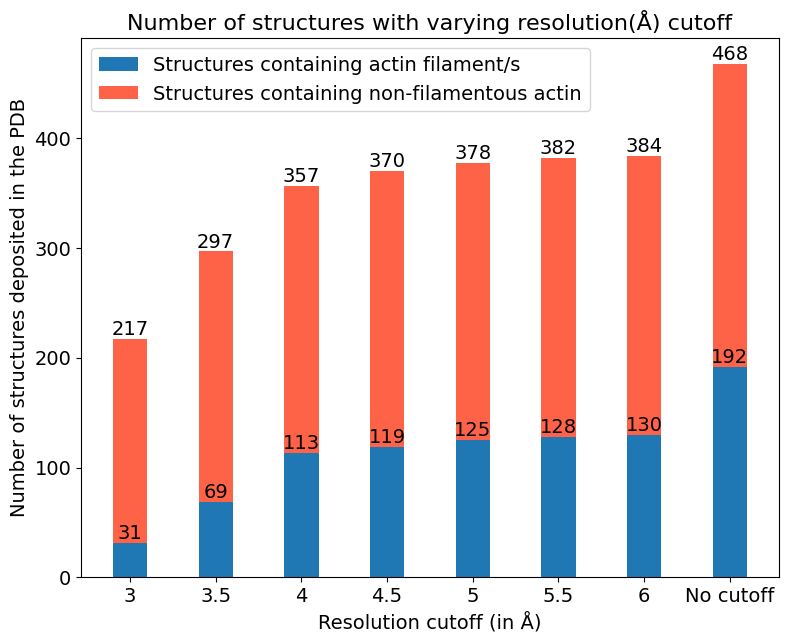

In [ ]:
#@title <font color = 'royalblue'> Resolution wise actin structures </font>

plot_dict = {}
plot_dict2 = {}
master_lst =[]
master_lst2 = []
res_cutoff = [3,3.5,4,4.5,5,5.5,6]
no_res_list_all = []
no_res_list_f = []

for ress in res_cutoff:
	loop_lst = []
	for index,row in df.iterrows():
		res = row['resolution']
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst.append(row['assembly_id'][0:4])
		except ValueError:
			no_res_list_all.append(row['assembly_id'][0:4])
			pass
	loop_lst = list(set(loop_lst))
	master_lst.append(len(loop_lst))
	loop_lst2 = []

	for index,row in actin_filaments_df.iterrows():
		res = row['resolution']#[1:]
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst2.append(row['assembly_id'][0:4])
		except ValueError:
			no_res_list_f.append(row['assembly_id'][0:4])
			pass
	loop_lst2 = list(set(loop_lst2))
	master_lst2.append(len(loop_lst2))
#print(master_lst,master_lst2)

no_res_list_all = list(set(no_res_list_all))
no_res_list_f = list(set(no_res_list_f))

for i in range(0,len(res_cutoff)):
  plot_dict[str(res_cutoff[i])] = master_lst[i] - master_lst2[i]

plot_dict['No cutoff'] = len(actin_pdb_ids) - len(filament_pdbs)

for i in range(0,len(res_cutoff)):
  plot_dict2[str(res_cutoff[i])] = master_lst2[i]

plot_dict2['No cutoff'] = len(filament_pdbs)

# print("non-filament actin structures: ", plot_dict)
# print("filament actin structures: ", plot_dict2)

x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

bars2 = ax.bar(x,y2, width = 0.4, label = 'Structures containing actin filament/s')
ax.bar_label(bars2)
bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.4, label = 'Structures containing non-filamentous actin')
ax.bar_label(bars)
ax.legend()
plt.xlabel('Resolution cutoff (in Å)')
plt.ylabel('Number of structures deposited in the PDB')
plt.title('Number of structures with varying resolution(Å) cutoff')

fig.set_size_inches(9, 7)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)

plt.savefig('./structures_vs_resolution_plot.png', dpi = 300)
plt.show()

In [ ]:
#@title <font color = 'royalblue'> JSON to Dataframe </font>
#markdown - For better visualization, convert the json object obtained from data API to a dataframe
#markdown - Each row of the dataframe corresponds to a single actin entity
#@markdown ## Attributes
#@markdown Entry point is entities
#@markdown - Actin entity ID
#@markdown - UniProt ID of actin entity
#@markdown - Chain ID (PDB and author)
#@markdown - Structure title
#@markdown - Resolution
#@markdown - Symmetry type
#@markdown - Sequence length (PDB)
#@markdown - Structure determination method
#@markdown - Sequence of actin entity (PDB)

ids_lst = json.dumps(actin_entity_ids)
query = '''
{
  polymer_entities(entity_ids: %s) {
rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_accession_info {
        initial_release_date
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
        }
      }
    }
    entity_poly {
      pdbx_seq_one_letter_code_can
      rcsb_sample_sequence_length
    }
    polymer_entity_instances {
      rcsb_polymer_entity_instance_container_identifiers {
        asym_id
        auth_asym_id
      }
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}

'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql"
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

master_lst = []
error_lst = []
for entity in result['polymer_entities']:
  entity_id = entity['rcsb_id']
  try:
    entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
    entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
    accessions = []
    init_rel_date = entity['entry']['rcsb_accession_info']['initial_release_date'].partition("T")[0]
    for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
      if acc['database_name'] == "UniProt":
        accessions.append(acc['database_accession'])
    uni_acc = ','.join(accessions)
    # entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    entity_uniprot_id = actin_uniprot_dict[entity_id[0:4]][0]
    pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    exptl_methods = []
    for method in entity['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    all_sym_in_assembly = []
    for assem in entity['entry']['assemblies']:
      for sym_type in assem['rcsb_struct_symmetry']:
        sym = sym_type['type']
        all_sym_in_assembly.append(sym)
    assembly_symmetry = ','.join(all_sym_in_assembly)
    structure_title = entity['entry']['struct']['title']
    #pdb chains
    pdb_chains = []
    auth_chains = []
    for chain_dict in entity['polymer_entity_instances']:
      pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
      auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
    asym_ids = ','.join(pdb_chains)
    auth_asym_ids = ','.join(auth_chains)
    master_lst.append([entity_id,init_rel_date,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
  except TypeError:
    # print(entity_id)
    error_lst.append(entity_id)
    try:
      init_rel_date = entity['entry']['rcsb_accession_info']['initial_release_date'].partition("T")[0]
    except:
      init_rel_date = 'none'
    try:
      entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
      entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
      entity_uniprot_id = actin_uniprot_dict[entity_id[0:4]][0]
      # entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    except TypeError:
      entity_seq = 'none'
      entity_seq_length = 'none'
      entity_uniprot_id = 'none'
    try:
      pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    except TypeError:
      pdb_resolution = 'none'
    try:
      exptl_methods = []
      for method in entity['entry']['exptl']:
        exptl_methods.append(method['method'])
      exptl_method = ','.join(exptl_methods)
    except TypeError:
      exptl_method = 'none'
    try:
      all_sym_in_assembly = []
      for assem in entity['entry']['assemblies']:
        for sym_type in assem['rcsb_struct_symmetry']:
          sym = sym_type['type']
          all_sym_in_assembly.append(sym)
      assembly_symmetry = ','.join(all_sym_in_assembly)
    except TypeError:
      assembly_symmetry = 'none'
    try:
      #pdb chains
      pdb_chains = []
      auth_chains = []
      for chain_dict in entity['polymer_entity_instances']:
        pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
        auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
      asym_ids = ','.join(pdb_chains)
      auth_asym_ids = ','.join(auth_chains)
    except TypeError:
      asym_ids = 'none'
      auth_asym_ids = 'none'
    structure_title = entity['entry']['struct']['title']
    master_lst.append([entity_id,init_rel_date,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
    pass

df_all = pd.DataFrame(master_lst,columns=['entity_id','date','uniprot_id','pdb_chain_id','auth_chain_id','structure_title','resolution','symmetry','seq_length', 'method','pdb_sequence'])
df_all.index+=1

print("Entities which have some missing field: ", error_lst,"\n")
#'6V6S_7', '8J07_67', '2W49_5', '2W4U_5', '7U8K_1'have at least one of the query variables missing

# data_table.DataTable(df_all)

Entities which have some missing field:  ['6V6S_7', '8J07_67', '7U8K_1', '2W49_5', '2W4U_5'] 



In [ ]:
#@title <font color = 'royalblue'> Add filament status and save dataframe </font>
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("150")')

# add filament status in the original dataset
df_all['filament_status'] = 'non_filament'

for index, row in df_all.iterrows():
	if row['entity_id'][0:4] in filament_pdbs:
		df_all.at[index, 'filament_status'] = row['filament_status'].replace("non_filament","filament")

filename = "./actin_dataset/actin_database_sheets/actin_all_entities_NA.xlsx"# add a date to the name
os.makedirs(os.path.dirname(filename), exist_ok=True)

#df3.to_excel(os.path.join(savepath,"actin_filament_entities_NA.xlsx"))
df_all.to_excel(filename)

master_lst_entries = []
for index, row in df_all.iterrows():
  pdb_id = row['entity_id'][0:4]
  actin_uniprot = row['uniprot_id']
  structure_title = row['structure_title']
  resolution = row['resolution']
  method = row['method']
  filament_status = row['filament_status']
  rel_date = row['date']
  master_lst_entries.append([pdb_id,rel_date,method,resolution,actin_uniprot,filament_status])

df_entries = pd.DataFrame(master_lst_entries,columns=['PDB ID','Date','Method','Resolution','Actin UniProt ID','Filament status'])
df_entries = df_entries.drop_duplicates()
df_entries.reset_index(drop = True, inplace=True)
df_entries.index+=1

df_entries.to_excel("./actin_dataset/actin_database_sheets/actin_all_PDBs.xlsx", index = False)
data_table.DataTable(df_entries,  num_rows_per_page=5)

,PDB ID,Date,Method,Resolution,Actin UniProt ID,Filament status
1,2OAN,2007-05-01,X-RAY DIFFRACTION,2.606,P60712,non_filament
2,3U4L,2012-04-25,X-RAY DIFFRACTION,2.4,P60712,non_filament
3,6ANU,2017-11-22,ELECTRON MICROSCOPY,7.0,P60709,filament
4,6F1T,2018-01-17,ELECTRON MICROSCOPY,3.5,Q6QAQ1,non_filament
5,6F38,2018-01-17,ELECTRON MICROSCOPY,6.7,Q6QAQ1,non_filament
...,...,...,...,...,...,...
464,6V63,2020-01-22,X-RAY DIFFRACTION,2.02,P63261,non_filament
465,6V62,2020-01-15,X-RAY DIFFRACTION,2.36,P63261,non_filament
466,6WK1,2020-06-17,X-RAY DIFFRACTION,1.89,P63261,non_filament
467,6WK2,2020-06-17,X-RAY DIFFRACTION,1.76,P63261,non_filament
